<a href="https://colab.research.google.com/github/evildead23151/ML-Projects/blob/main/brain_tumor_detection_project_MACS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Introduction

The project focuses on applying state-of-the-art convolutional neural network architectures to automate and improve the classification of brain tumor MRI scans. By preprocessing images, augmenting the dataset, and experimenting with leading models like VGG-16, ResNet, and EfficientNet, the goal is to achieve robust and accurate tumor detection for clinical support.

In [ ]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [ ]:
import os
import shutil
import json
import random
from sklearn.model_selection import train_test_split
from tqdm import tqdm

CLASSIFICATION_SRC = '/kaggle/input/brain-tumor-classification-mri'
DETECTION_SRC = '/kaggle/input/brain-tumor-detection'
DETECTION_MASK_RCNN_SRC = os.path.join(DETECTION_SRC, 'Br35H-Mask-RCNN')
DETECTION_NO_TUMOR_SRC = os.path.join(DETECTION_SRC, 'no')
ANNOTATION_FILE = os.path.join(DETECTION_MASK_RCNN_SRC, 'annotations_all.json')
OUTPUT_DIR = '/kaggle/working/Combined_Classification_Data'
OUTPUT_TRAIN = os.path.join(OUTPUT_DIR, 'Training')
OUTPUT_TEST = os.path.join(OUTPUT_DIR, 'Testing')
CLASSES = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
LABEL_MAP = {
    'glioma_tumor': 'glioma_tumor',
    'meningioma_tumor': 'meningioma_tumor',
    'pituitary_tumor': 'pituitary_tumor',
    'glioma': 'glioma_tumor',
    'meningioma': 'meningioma_tumor',
    'pituitary': 'pituitary_tumor'
}
def create_output_dirs():
    """Creates the necessary output directory structure."""
    print(f"Creating output directory: {OUTPUT_DIR}")
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)

    for split in [OUTPUT_TRAIN, OUTPUT_TEST]:
        for class_name in CLASSES:
            os.makedirs(os.path.join(split, class_name), exist_ok=True)
def copy_classification_data():
    """Copies the standard classification dataset."""
    print(f"Copying data from {CLASSIFICATION_SRC}...")
    for split in ['Training', 'Testing']:
        source_split_dir = os.path.join(CLASSIFICATION_SRC, split)
        output_split_dir = OUTPUT_TRAIN if split == 'Training' else OUTPUT_TEST

        if not os.path.exists(source_split_dir):
            print(f"  Warning: Directory not found, skipping: {source_split_dir}")
            continue

        for class_name in CLASSES:
            source_class_dir = os.path.join(source_split_dir, class_name)
            target_class_dir = os.path.join(output_split_dir, class_name)

            if not os.path.exists(source_class_dir):
                print(f"  Warning: Directory not found, skipping: {source_class_dir}")
                continue

            files = os.listdir(source_class_dir)
            for filename in tqdm(files, desc=f'  Copying {split}/{class_name}'):
                shutil.copy(os.path.join(source_class_dir, filename), target_class_dir)
def process_detection_data():
    """Processes the detection dataset using the JSON annotations."""
    print(f"Processing data from {DETECTION_MASK_RCNN_SRC}...")

    try:
        with open(ANNOTATION_FILE, 'r') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"  Error: Annotation file not found: {ANNOTATION_FILE}")
        return
    except json.JSONDecodeError:
        print(f"  Error: Could not decode JSON from {ANNOTATION_FILE}")
        return

    try:
        cat_id_to_name = {cat['id']: cat['name'] for cat in data['categories']}
        img_id_to_filename = {img['id']: img['file_name'] for img in data['images']}
    except KeyError:
        print("  Error: JSON format unknown. Expected keys 'categories' and 'images'.")
        return

    image_to_label_map = {}
    for ann in data.get('annotations', []):
        img_id = ann['image_id']
        cat_id = ann['category_id']
        filename = img_id_to_filename.get(img_id)
        raw_label = cat_id_to_name.get(cat_id)

        if filename and raw_label and filename not in image_to_label_map:
            mapped_label = LABEL_MAP.get(raw_label)
            if mapped_label:
                image_to_label_map[filename] = mapped_label

    detection_splits = {
        'TRAIN': OUTPUT_TRAIN,
        'VAL': OUTPUT_TRAIN,
        'TEST': OUTPUT_TEST
    }

    for split_name, target_split_dir in detection_splits.items():
        source_split_dir = os.path.join(DETECTION_MASK_RCNN_SRC, split_name)

        if not os.path.exists(source_split_dir):
            print(f"  Info: Detection split not found, skipping: {source_split_dir}")
            continue

        files = [f for f in os.listdir(source_split_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for filename in tqdm(files, desc=f'  Processing detection/{split_name}'):
            source_file_path = os.path.join(source_split_dir, filename)
            label = image_to_label_map.get(filename, 'no_tumor')
            target_dir = os.path.join(target_split_dir, label)

            shutil.copy(source_file_path, target_dir)
def process_no_tumor_folder():
    """Copies and splits the separate 'no' folder."""
    print(f"Processing data from {DETECTION_NO_TUMOR_SRC}...")

    if not os.path.exists(DETECTION_NO_TUMOR_SRC):
        print(f"  Warning: Directory not found, skipping: {DETECTION_NO_TUMOR_SRC}")
        return

    files = [f for f in os.listdir(DETECTION_NO_TUMOR_SRC) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not files:
        print("  No image files found in 'no' folder.")
        return

    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

    target_train_dir = os.path.join(OUTPUT_TRAIN, 'no_tumor')
    target_test_dir = os.path.join(OUTPUT_TEST, 'no_tumor')

    for filename in tqdm(train_files, desc="  Copying 'no' to Training"):
        shutil.copy(os.path.join(DETECTION_NO_TUMOR_SRC, filename), target_train_dir)

    for filename in tqdm(test_files, desc="  Copying 'no' to Testing"):
        shutil.copy(os.path.join(DETECTION_NO_TUMOR_SRC, filename), target_test_dir)
if __name__ == "__main__":
    from sklearn.model_selection import train_test_split

    create_output_dirs()
    copy_classification_data()
    process_detection_data()
    process_no_tumor_folder()

    print("\n-------------------------------------------------")
    print("✅ All datasets combined successfully!")
    print(f"Your new dataset is ready in: {OUTPUT_DIR}")
    print("-------------------------------------------------")

Creating output directory: /kaggle/working/Combined_Classification_Data
Copying data from /kaggle/input/brain-tumor-classification-mri...


  Copying Testing/pituitary_tumor: 100%|██████████| 74/74 [00:00<00:00, 173.26it/s]


Processing data from /kaggle/input/brain-tumor-detection/Br35H-Mask-RCNN...
  Error: JSON format unknown. Expected keys 'categories' and 'images'.
Processing data from /kaggle/input/brain-tumor-detection/no...


  Copying 'no' to Testing: 100%|██████████| 300/300 [00:01<00:00, 245.37it/s]


-------------------------------------------------
✅ All datasets combined successfully!
Your new dataset is ready in: /kaggle/working/Combined_Classification_Data
-------------------------------------------------


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,MaxPooling2D,Conv2D,Flatten,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.layers import Rescaling

2025-10-21 08:33:06.001648: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761035586.184309      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761035586.232957      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Image Preprocessing and Dataset Preparation

This section details resizing MRI images to standard dimensions and organizing datasets for training and validation.

In [ ]:
train_dir = '/kaggle/working/Combined_Classification_Data/Training'
test_dir = '/kaggle/working/Combined_Classification_Data/Testing'

train_ds=keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/Combined_Classification_Data/Training',
    batch_size=32,
    image_size=(224,224),
    validation_split=0.2,
    subset="training",
    seed=123,

)

validation_ds=keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/Combined_Classification_Data/Training',
    batch_size=32,
    image_size=(224,224),
    validation_split=0.2,
    subset="validation",
    seed=123,

)

test_ds=keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/Combined_Classification_Data/Testing',
    batch_size=32,
    image_size=(224,224),
    shuffle=False
)

Found 4070 files belonging to 4 classes.
Using 3256 files for training.


I0000 00:00:1761035597.705133      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 4070 files belonging to 4 classes.
Using 814 files for validation.
Found 694 files belonging to 4 classes.


# Image Normalization Techniques

Explains methods used to scale MRI pixel values for optimal model learning.

In [ ]:
def process(image,label):
    image=tf.cast(image/255. ,tf.float32)
    return image,label

train_ds=train_ds.map(process)
validation_ds=validation_ds.map(process)

# Data Augmentation Strategies

Discusses the use of transformations to increase dataset diversity and improve generalization.

In [ ]:
# # This saves the original, un-augmented images in memory.
# train_ds = train_ds.cache()
# validation_ds = validation_ds.cache()
# test_ds = test_ds.cache()

In [ ]:
# from keras.preprocessing import image
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen=ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
# )

# validation_datagen=ImageDataGenerator(
#     rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
# )

# test_datagen=ImageDataGenerator(
#     rescale=1./255,
# )

# train_generator=train_datagen.flow_from_directory(
#     train_ds,
#     target_size=(224,224),
#     batch_size=32,
# )

# VGG-16 Architecture Details

Summarizes key layers and components of the VGG-16 network.

In [ ]:
model=Sequential()
model.add(Rescaling(1./255, input_shape=(224, 224, 3))),

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',name='block1_conv1',input_shape=(224,224,3)))
model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',name='block1_conv2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block1_pool'))

model.add(Conv2D(128,kernel_size=(3,3),padding='same',name='block2_conv1',activation='relu'))
model.add(Conv2D(128,kernel_size=(3,3),padding='same',name='block2_conv2',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block2_pool'))

model.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',name='block3_conv1'))
model.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',name='block3_conv2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block3_pool'))

model.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',name='block4_conv1'))
model.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',name='block4_conv2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block4_pool'))

model.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',name='block5_conv1'))
model.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',name='block5_conv2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block5_pool'))
# flatten layer
model.add(Flatten())
# dense layers
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(4,activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 128,973,124 (491.99 MB)

 Trainable params: 128,970,180 (491.98 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# VGG-16 Model Training

Outlines the approach, epochs, and hyperparameters used for training.

In [ ]:
h=model.fit(train_ds,epochs=10,validation_data=validation_ds)


Epoch 1/10


I0000 00:00:1761035609.190808      67 service.cc:148] XLA service 0x7dacc0001cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761035609.191419      67 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761035610.075272      67 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1761035631.701065      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


102/102 ━━━━━━━━━━━━━━━━━━━━ 80s 493ms/step - accuracy: 0.4617 - loss: 27.0271 - val_accuracy: 0.2039 - val_loss: 1.8981
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.6183 - loss: 1.3167 - val_accuracy: 0.2027 - val_loss: 2.7517
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step - accuracy: 0.6366 - loss: 1.0682 - val_accuracy: 0.3514 - val_loss: 1.3662
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.6797 - loss: 0.9415 - val_accuracy: 0.1990 - val_loss: 1.8508
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.6870 - loss: 0.9215 - val_accuracy: 0.2027 - val_loss: 3.9589
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.7124 - loss: 0.8347 - val_accuracy: 0.2002 - val_loss: 3.9605
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.7414 - loss: 0.6597 - val_accuracy: 0.3440 - val_loss: 1.9285
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - accuracy: 0.7609 - loss: 0.6517 - va

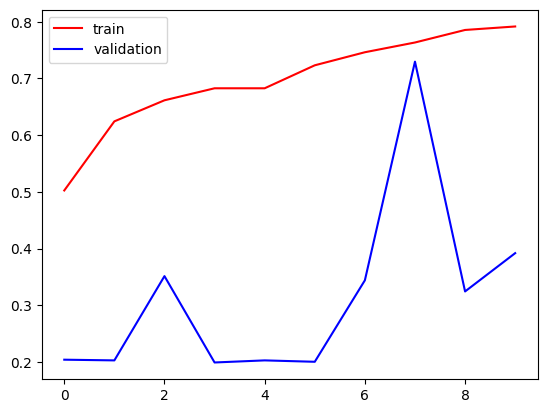

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'],color='red',label='train')
plt.plot(h.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()


# Transfer Learning with Pretrained VGG-16

Describes leveraging pretrained weights for efficient and accurate feature extraction.



In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
convo_base=VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
convo_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model1=Sequential()
model1.add(convo_base)
model1.add(Flatten())
model1.add(Dense(256,activation='relu'))
model1.add(Dropout(0.4))
model1.add(Dense(4,activation='softmax'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 21,138,500 (80.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
convo_base.trainable=False

In [ ]:
model1.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

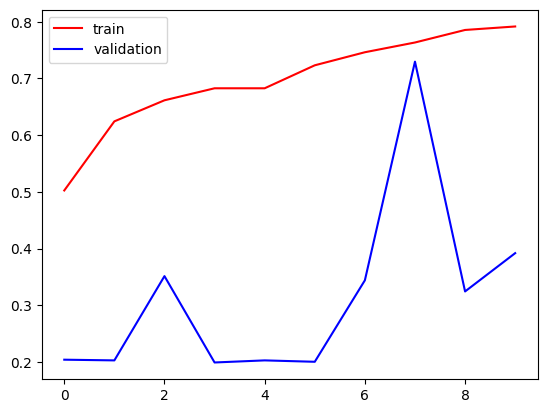

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'],color='red',label='train')
plt.plot(h.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
h=model1.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.6039 - loss: 2.1611 - val_accuracy: 0.8329 - val_loss: 0.4150
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8254 - loss: 0.4513 - val_accuracy: 0.8882 - val_loss: 0.3396
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8683 - loss: 0.3384 - val_accuracy: 0.8968 - val_loss: 0.2637
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.8929 - loss: 0.2856 - val_accuracy: 0.9066 - val_loss: 0.2363
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9022 - loss: 0.2384 - val_accuracy: 0.9177 - val_loss: 0.2205
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9144 - loss: 0.2097 - val_accuracy: 0.9263 - val_loss: 0.2084
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9341 - loss: 0.1637 - val_accuracy: 0.9361 - val_loss: 0.1815
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9375 - loss: 0.1544 - val_ac

# ResNet Model Implementation

Covers the introduction and application of ResNet for tumor classification.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input ,decode_predictions
convo_base=ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

convo_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras.models import Model
base_model = convo_base
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block1_out':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

# dense layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # For regularization
predictions = Dense(4, activation='softmax')(x)

model2 = Model(inputs=base_model.input, outputs=predictions)
model2.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 9,982,468 (38.08 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam
model2.compile(optimizer=Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
h2=model2.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 42s 204ms/step - accuracy: 0.4762 - loss: 1.1665 - val_accuracy: 0.4275 - val_loss: 1.3046
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7506 - loss: 0.6642 - val_accuracy: 0.4324 - val_loss: 1.2769
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7956 - loss: 0.5205 - val_accuracy: 0.5283 - val_loss: 1.0688
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8449 - loss: 0.4204 - val_accuracy: 0.7776 - val_loss: 0.6228
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8549 - loss: 0.3777 - val_accuracy: 0.8489 - val_loss: 0.4025
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8880 - loss: 0.3100 - val_accuracy: 0.8563 - val_loss: 0.4007
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9029 - loss: 0.2629 - val_accuracy: 0.8624 - val_loss: 0.3446
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9269 - loss: 0.2227 - val_ac

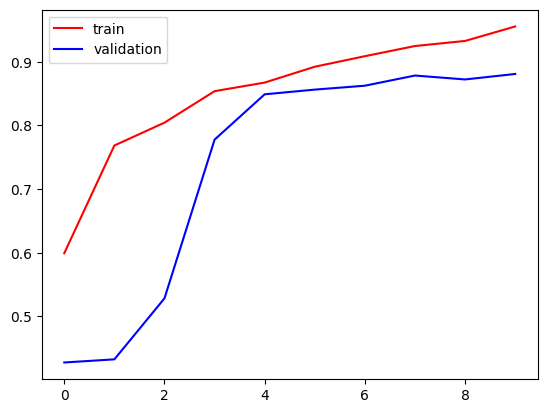

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h2.history['accuracy'],color='red',label='train')
plt.plot(h2.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

# EfficientNetB0 Model Integration

Highlights the use of this modern architecture for performance improvement.

In [ ]:
from tensorflow.keras.applications import EfficientNetB0


#extracting the convo base
convo_base3=EfficientNetB0(
    weights='imagenet',
    include_top=False,# dense layer include mhi
    input_shape=(224,224,3)
)

convo_base3.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
convo_base3.trainable = False

In [ ]:
from tensorflow.keras.models import Model
x = convo_base3.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)


model3 = Model(inputs=convo_base3.input, outputs=predictions)
model3.summary()

Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_2[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,707,495 (17.96 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
train_ds_eff=keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/Combined_Classification_Data/Training',
    # labels='inferred',
    # label_mode='int',
    batch_size=32,
    image_size=(224,224),
    validation_split=0.2,
    subset="training",
    seed=123,

)

validation_ds_eff=keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/Combined_Classification_Data/Training',
    # labels='inferred',
    # label_mode='int',
    batch_size=32,
    image_size=(224,224),
    validation_split=0.2,
    subset="validation",
    seed=123,

)

test_ds_eff=keras.utils.image_dataset_from_directory(
    directory='/kaggle/working/Combined_Classification_Data/Testing',
    # labels='inferred',
    # label_mode='int',
    batch_size=32,
    image_size=(224,224),
    shuffle=False
)
# every image stored as value in the range of 0 to 255
# we will normalize this value to 0-1

Found 4070 files belonging to 4 classes.
Using 3256 files for training.
Found 4070 files belonging to 4 classes.
Using 814 files for validation.
Found 694 files belonging to 4 classes.


In [ ]:
from tensorflow.keras.optimizers import Adam
model3.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
h3=model3.fit(train_ds_eff,epochs=10,validation_data=validation_ds_eff)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 49s 243ms/step - accuracy: 0.7178 - loss: 0.7118 - val_accuracy: 0.8636 - val_loss: 0.3179
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8876 - loss: 0.3174 - val_accuracy: 0.8403 - val_loss: 0.3605
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8928 - loss: 0.2805 - val_accuracy: 0.8956 - val_loss: 0.2433
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9035 - loss: 0.2606 - val_accuracy: 0.9103 - val_loss: 0.2194
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9149 - loss: 0.2149 - val_accuracy: 0.9201 - val_loss: 0.1959
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9206 - loss: 0.2118 - val_accuracy: 0.9140 - val_loss: 0.2308
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9326 - loss: 0.1778 - val_accuracy: 0.9263 - val_loss: 0.1822
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9378 - loss: 0.1743 - val_ac

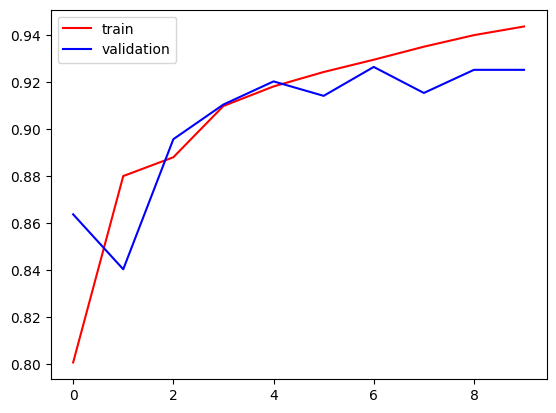

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h3.history['accuracy'],color='red',label='train')
plt.plot(h3.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

# Custom Neural Network Design

Details any unique or novel neural network designs tested in the project.

In [ ]:
model4=Sequential()
model4.add(Rescaling(1./255, input_shape=(224, 224, 3))),

model4.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',name='block1_conv1',input_shape=(224,224,3)))
model4.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',name='block1_conv2'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block1_pool'))

model4.add(Conv2D(128,kernel_size=(3,3),padding='same',name='block2_conv1',activation='relu'))
model4.add(Conv2D(128,kernel_size=(3,3),padding='same',name='block2_conv2',activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block2_pool'))

model4.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',name='block3_conv1'))
model4.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',name='block3_conv2'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block3_pool'))

model4.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',name='block4_conv1'))
model4.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',name='block4_conv2'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block4_pool'))

model4.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',name='block5_conv1'))
model4.add(Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',name='block5_conv2'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block5_pool'))

model4.add(Conv2D(1024,kernel_size=(3,3),padding='same',activation='relu',name='block6_conv1'))
model4.add(Conv2D(1024,kernel_size=(3,3),padding='same',activation='relu',name='block6_conv2'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same',name='block6_pool'))
# flatten layer
model4.add(Flatten())
# dense layers
model4.add(Dense(4096,activation='relu'))
model4.add(Dropout(0.4))
model4.add(Dense(4096,activation='relu'))
model4.add(Dropout(0.4))
model4.add(Dense(4,activation='softmax'))

In [ ]:
model4.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block6_conv1 (Conv2D)           │ (None, 7, 7, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 107,483,460 (410.02 MB)

 Trainable params: 107,478,468 (410.00 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [ ]:
model4.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
h4=model4.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 47s 310ms/step - accuracy: 0.3823 - loss: 14.0478 - val_accuracy: 0.3956 - val_loss: 1.3535
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.5531 - loss: 1.1755 - val_accuracy: 0.3956 - val_loss: 1.9802
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.6219 - loss: 0.9877 - val_accuracy: 0.2039 - val_loss: 2.6268
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.6853 - loss: 0.8886 - val_accuracy: 0.2039 - val_loss: 2.7339
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.6674 - loss: 0.9315 - val_accuracy: 0.3956 - val_loss: 1.6671
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.7048 - loss: 0.7843 - val_accuracy: 0.3808 - val_loss: 1.8186
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.7455 - loss: 0.6793 - val_accuracy: 0.6658 - val_loss: 0.8030
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.7632 - loss: 

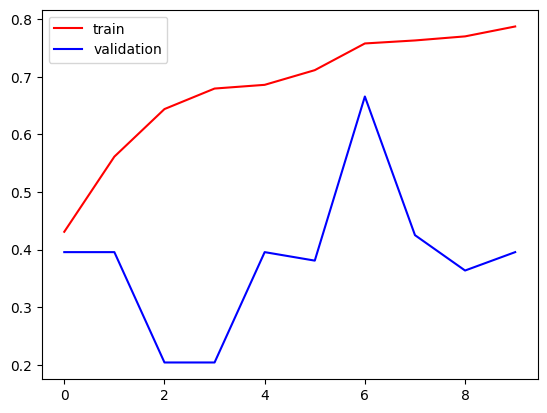

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h4.history['accuracy'],color='red',label='train')
plt.plot(h4.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()